In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train_sample = train.sample(frac=0.05)

In [4]:
test = pd.read_csv('test.csv')

*****************************************************************************************************

In [5]:
train_sample

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
29974,4f96b00c6b7bad02,""" or in this case, """"coreographic needs""""""",0,0,0,0,0,0
62058,a609ef9b6cadf2b2,"marakis: your reality, which we're well aware ...",0,0,0,0,0,0
34103,5af5d9315aa7d5eb,Flogging a dead horse,0,0,0,0,0,0
104472,2eeea8553ec04428,because I am a huge asshole,1,0,1,0,1,0
31189,52d10ee6623d4981,Note what is says at Help:Merging#Closing/arch...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
125293,9e2cf6bc445a59e9,"message \n\nBro, this is the internet not cybe...",0,0,0,0,0,0
6092,10454ebc4f169b29,"""\n\nThe Ezekiel passage is quoted in the Molo...",0,0,0,0,0,0
91414,f46e5246900e33d4,Thank you for experimenting with Wikipedia. Y...,0,0,0,0,0,0
132800,c684f402e7ecb50f,"""\nActually, you have found only one that says...",0,0,0,0,0,0


In [6]:
train_sample[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']].apply(pd.Series.value_counts)

,malignant,highly_malignant,rude,threat,abuse,loathe
0,7238,7900,7554,7961,7582,7918
1,741,79,425,18,397,61


In [7]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


*****************************************************************************************************

In [8]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7979 entries, 29974 to 42077
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                7979 non-null   object
 1   comment_text      7979 non-null   object
 2   malignant         7979 non-null   int64 
 3   highly_malignant  7979 non-null   int64 
 4   rude              7979 non-null   int64 
 5   threat            7979 non-null   int64 
 6   abuse             7979 non-null   int64 
 7   loathe            7979 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 561.0+ KB


*****************************************************************************************************

C:\Users\Usuario\anaconda3\envs\spyder1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


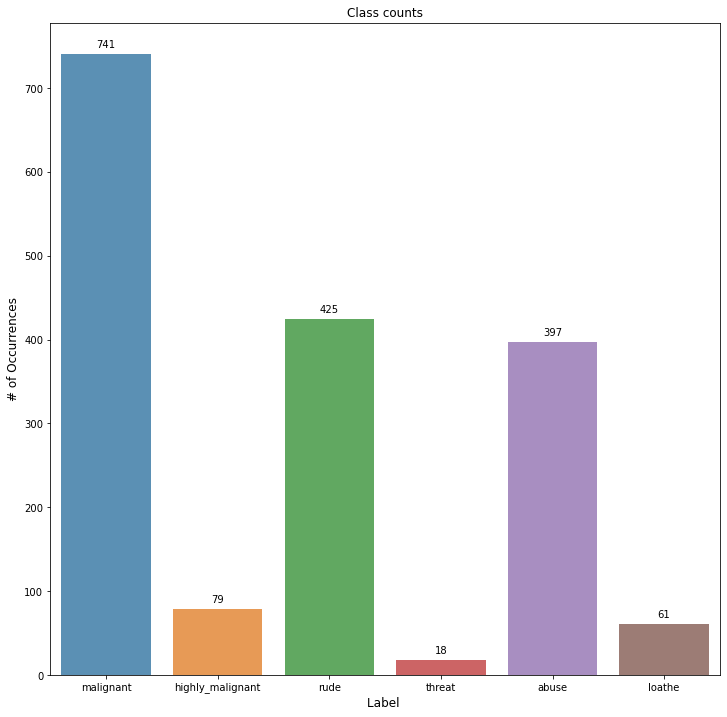

In [9]:
x=train_sample.iloc[:,2:].sum()
plt.figure(figsize=(12,12))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Class counts")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

*****************************************************************************************************

In [10]:
#Remove Stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    return text

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_sample['comment_text'] = train_sample['comment_text'].apply(lambda x: remove_stopwords(x))
train_sample['comment_text'] = train_sample['comment_text'].apply(lambda x:clean_text(x))
train_sample['comment_text'] = train_sample['comment_text'].apply(stemming)

*****************************************************************************************************

In [11]:
y = train_sample.iloc[:,3:]

In [12]:
y

,highly_malignant,rude,threat,abuse,loathe
29974,0,0,0,0,0
62058,0,0,0,0,0
34103,0,0,0,0,0
104472,0,1,0,1,0
31189,0,0,0,0,0
...,...,...,...,...,...
125293,0,0,0,0,0
6092,0,0,0,0,0
91414,0,0,0,0,0
132800,0,0,0,0,0


In [13]:
x_train, x_test, y_train, y_test = train_test_split(train_sample['comment_text'], train_sample.iloc[:,3:], test_size=0.2, random_state=9)

In [14]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', BinaryRelevance(LogisticRegression(solver='sag'))),
            ])
pipeline.fit(x_train, y_train)
predictions = pipeline.predict(x_test)


print('Accuracy = ', accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.9423558897243107
F1 score is  0.3153153153153153
Hamming Loss is  0.01904761904761905


*****************************************************************************************************

In [15]:
pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', ClassifierChain(LogisticRegression(solver='sag'))),
            ])
pipeline.fit(x_train, y_train)
predictions = pipeline.predict(x_test)

print('Accuracy = ', accuracy_score(y_test,predictions))
print('F1 score is ',f1_score(y_test, predictions, average="micro"))
print('Hamming Loss is ', hamming_loss(y_test, predictions))

Accuracy =  0.9411027568922306
F1 score is  0.2818181818181818
Hamming Loss is  0.019799498746867168
